<a href="https://colab.research.google.com/github/razaali0123/Machine_Learning/blob/master/IDA_ML_Project_805145.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IDA ML SS20 SEMESTER PROJECT**

# Topic = Detecting Defective Lasers

### Name: Raza Ali
### Matriculation Number:  805145


### **Problem Statement**

For the purpose of quality assurance, a manufacturer of medical lasers wants to introducea system which recognizes defective products. For the lasers produced, a constant lightoutput with a frequency as constant as possible is desired. Certain fluctuations are accep-table; Lasers in which the power fluctuates to an intolerable extent should be sorted out.For this purpose, the intensity of each laser is measured for one minute – one measurementper second. 

### **Goal**

In order to classify faulty and non-faulty lasers, we have to train-test different models and compare there predictive power using a feasible metric

### **Steps towards Effective and Efficient solution**

The following steps are taken to come up with the classification model:
* Loading Data

* Insight into the data

* Dimention View

* 3-d View of Dimention

* Using SVM Kernels to visualize decision boundary in 2-d space

* Modelling

* Making a mask for nested cross validation

* Nested Cross validation

* SVM - tuning kernel function, Slack variable (C) and gamma value.

* Accuracy metrics of SVM

* KNN - tuning n_nearest_neighbors

* Accuracy metrics of KNN

* Random Forest - Tuning max_depth and n_estimators

* Accuracy metrics of Random Forest

* Decison Tree - Tuning max-depth

* Accuracy metrics of Decision Tree

* Logistic Regression - Tuning slack variable C

* Accuracy metric of logistic regression




In [ ]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

### **Loading data**

In [ ]:
mat = scipy.io.loadmat('laser.mat')
data = mat['X']
label = mat['Y'].reshape(-1)

### **Insight into the data**

Text(0.5, 1.0, 'count of the labels')

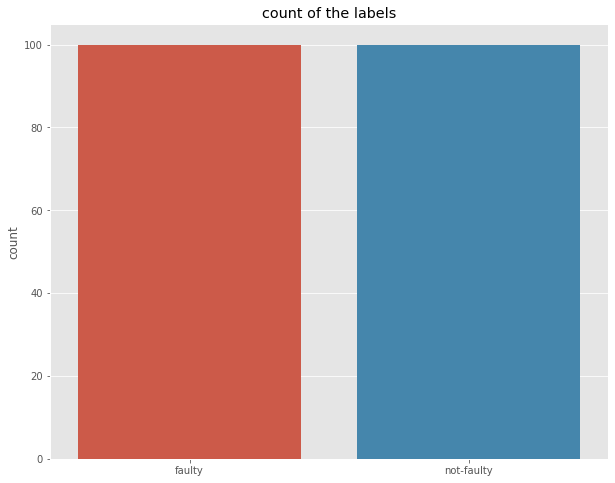

In [ ]:
plt.style.use('ggplot')
name = ["faulty" if x==-1 else "not-faulty" for x in label]
plt.subplots(figsize = (10,8))
sns.countplot(name)
plt.title("count of the labels")

the number of missing values are 0


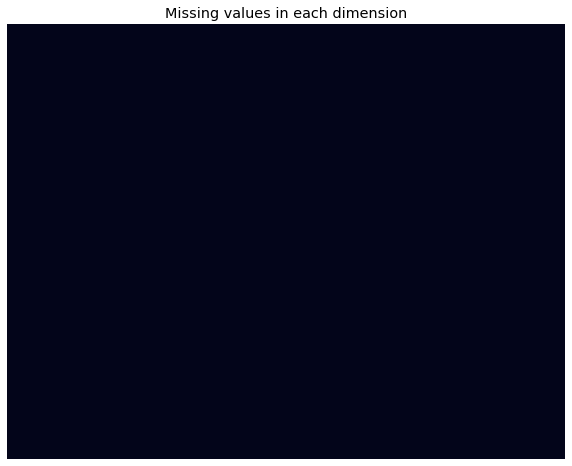

In [ ]:
missing = np.isnan(data)
fig, ax = plt.subplots(figsize = (10,8))
print("the number of missing values are", np.sum(missing))
plt.title("Missing values in each dimension")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sns.heatmap(missing, cbar= False)

### **Plot as a series**

In [ ]:
def plot(n, data, label):
  fig, axs = plt.subplots(1,n, figsize = (18,8))
  plt.style.use('ggplot')
  for i in range(len(axs)):
    axs[i].plot(np.arange(60), data[i,:], label = label[i])
    axs[i].legend()

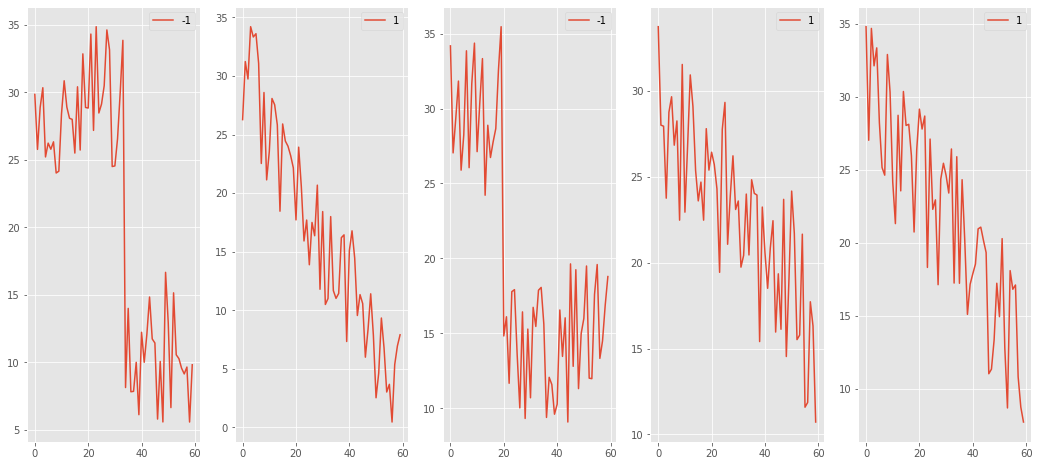

In [ ]:
plot(5, data, label)

### **Mean Values of dimensions**

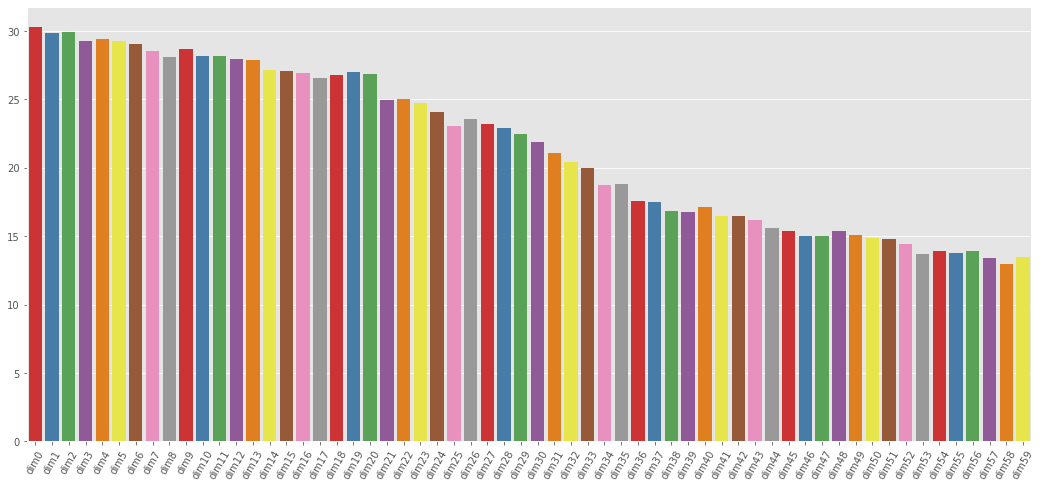

In [ ]:
names = ["dim"+str(i) for i in range(data.shape[1])]
means = np.mean(data, axis = 0)
plt.figure(figsize = (18,8))
plt.xticks(rotation = 60)
sns.barplot(names, means, palette= 'Set1')


### **Outliers detections**

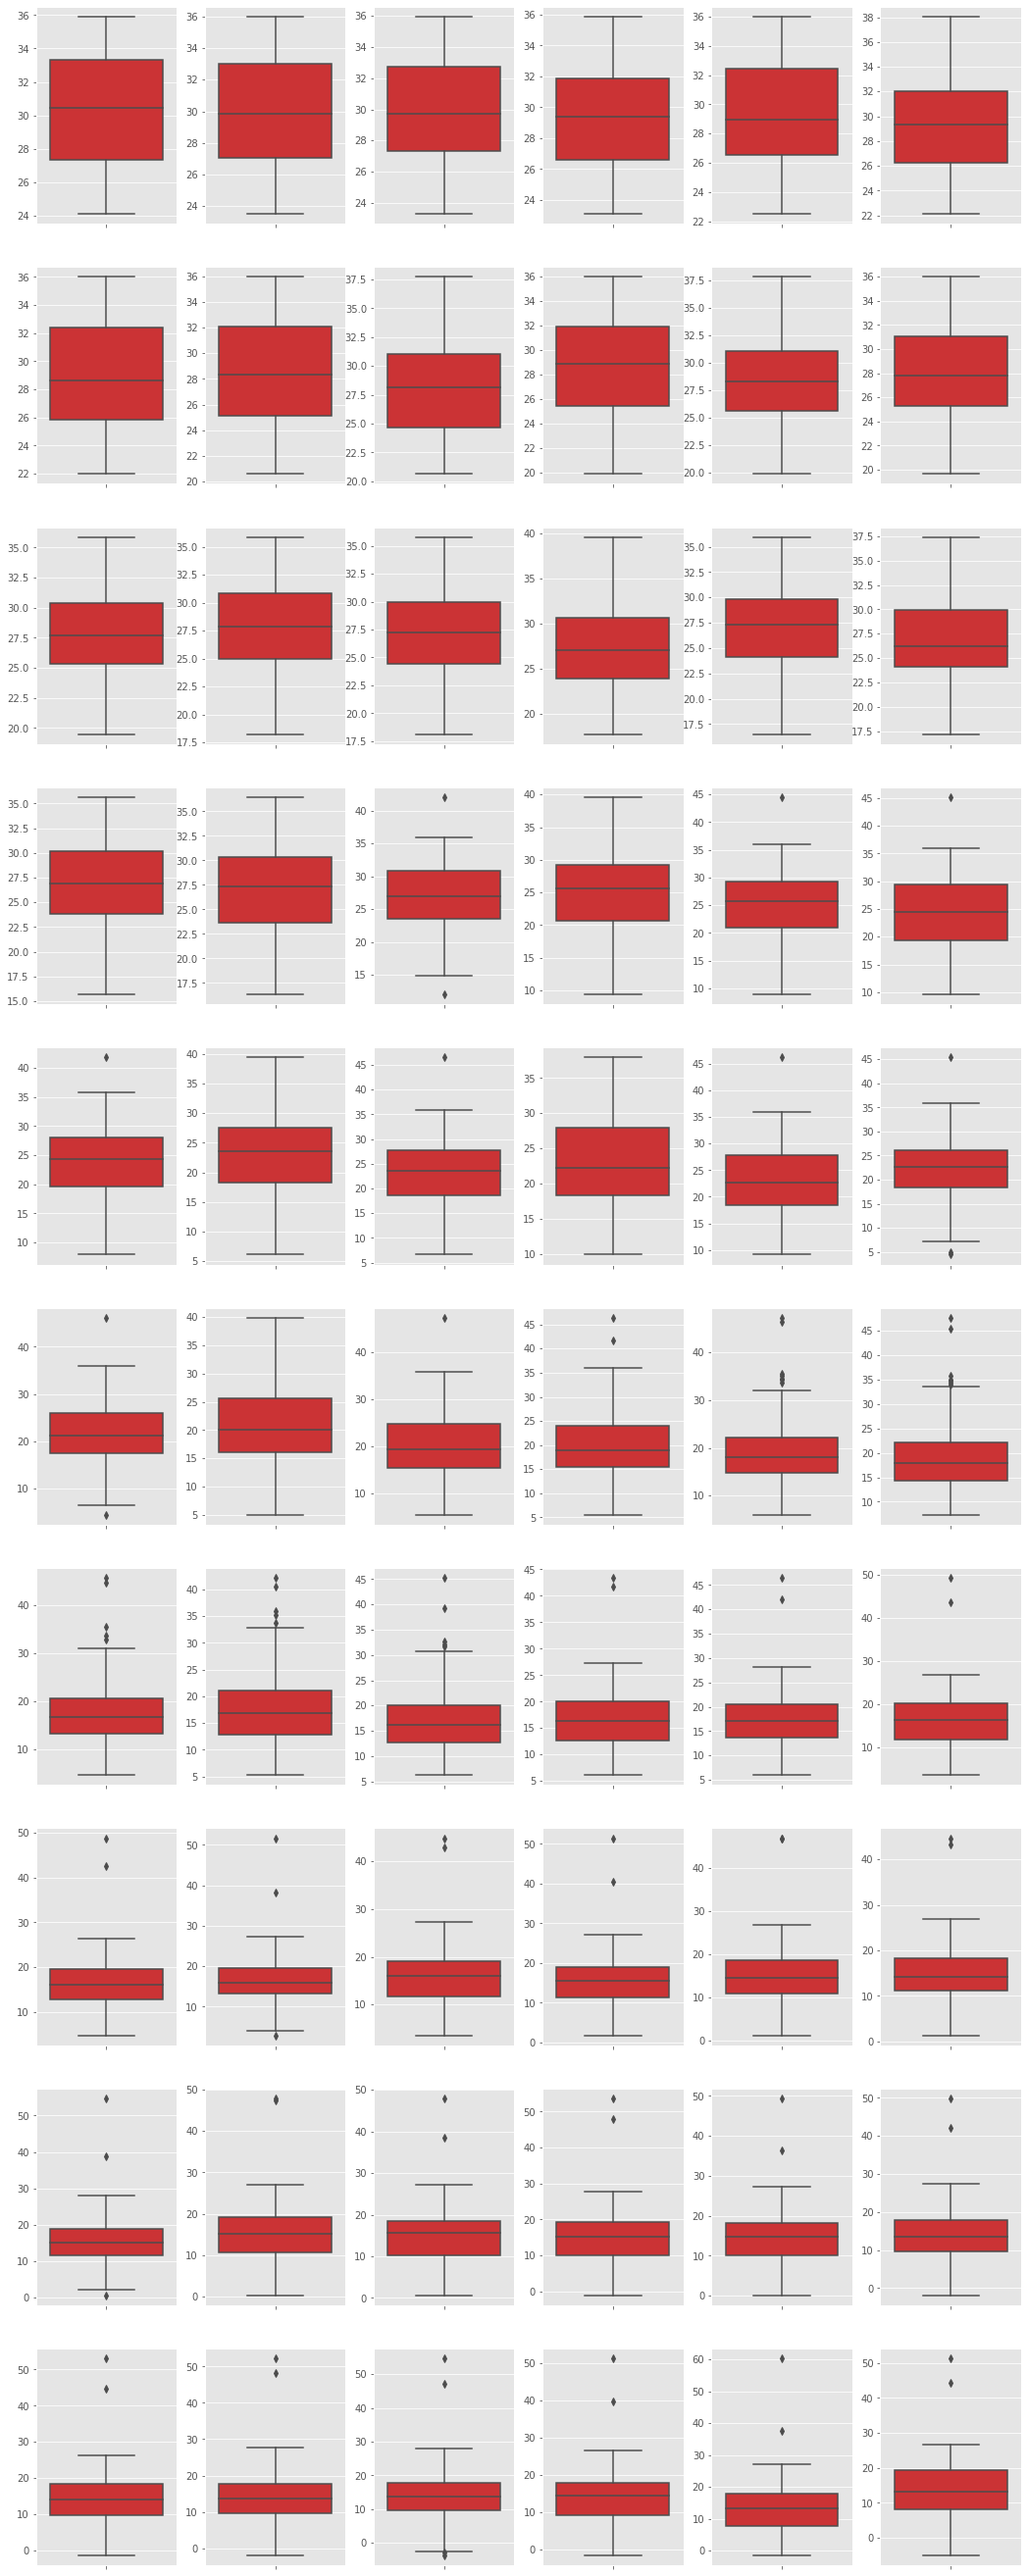

In [ ]:
fig, ax = plt.subplots(10,6, figsize = (18,48))
ax = ax.reshape(-1)
for i in range(60):
  sns.boxplot(data[:,i], ax = ax[i], palette= 'Set1', orient="v")

* As we move along the features, we find some outliers which have a value very much away from the mean.

* Some of them are very near to the upper whisker hence they won’t affect our classification so much.


### **Histogram/ Checking for distribution of features**

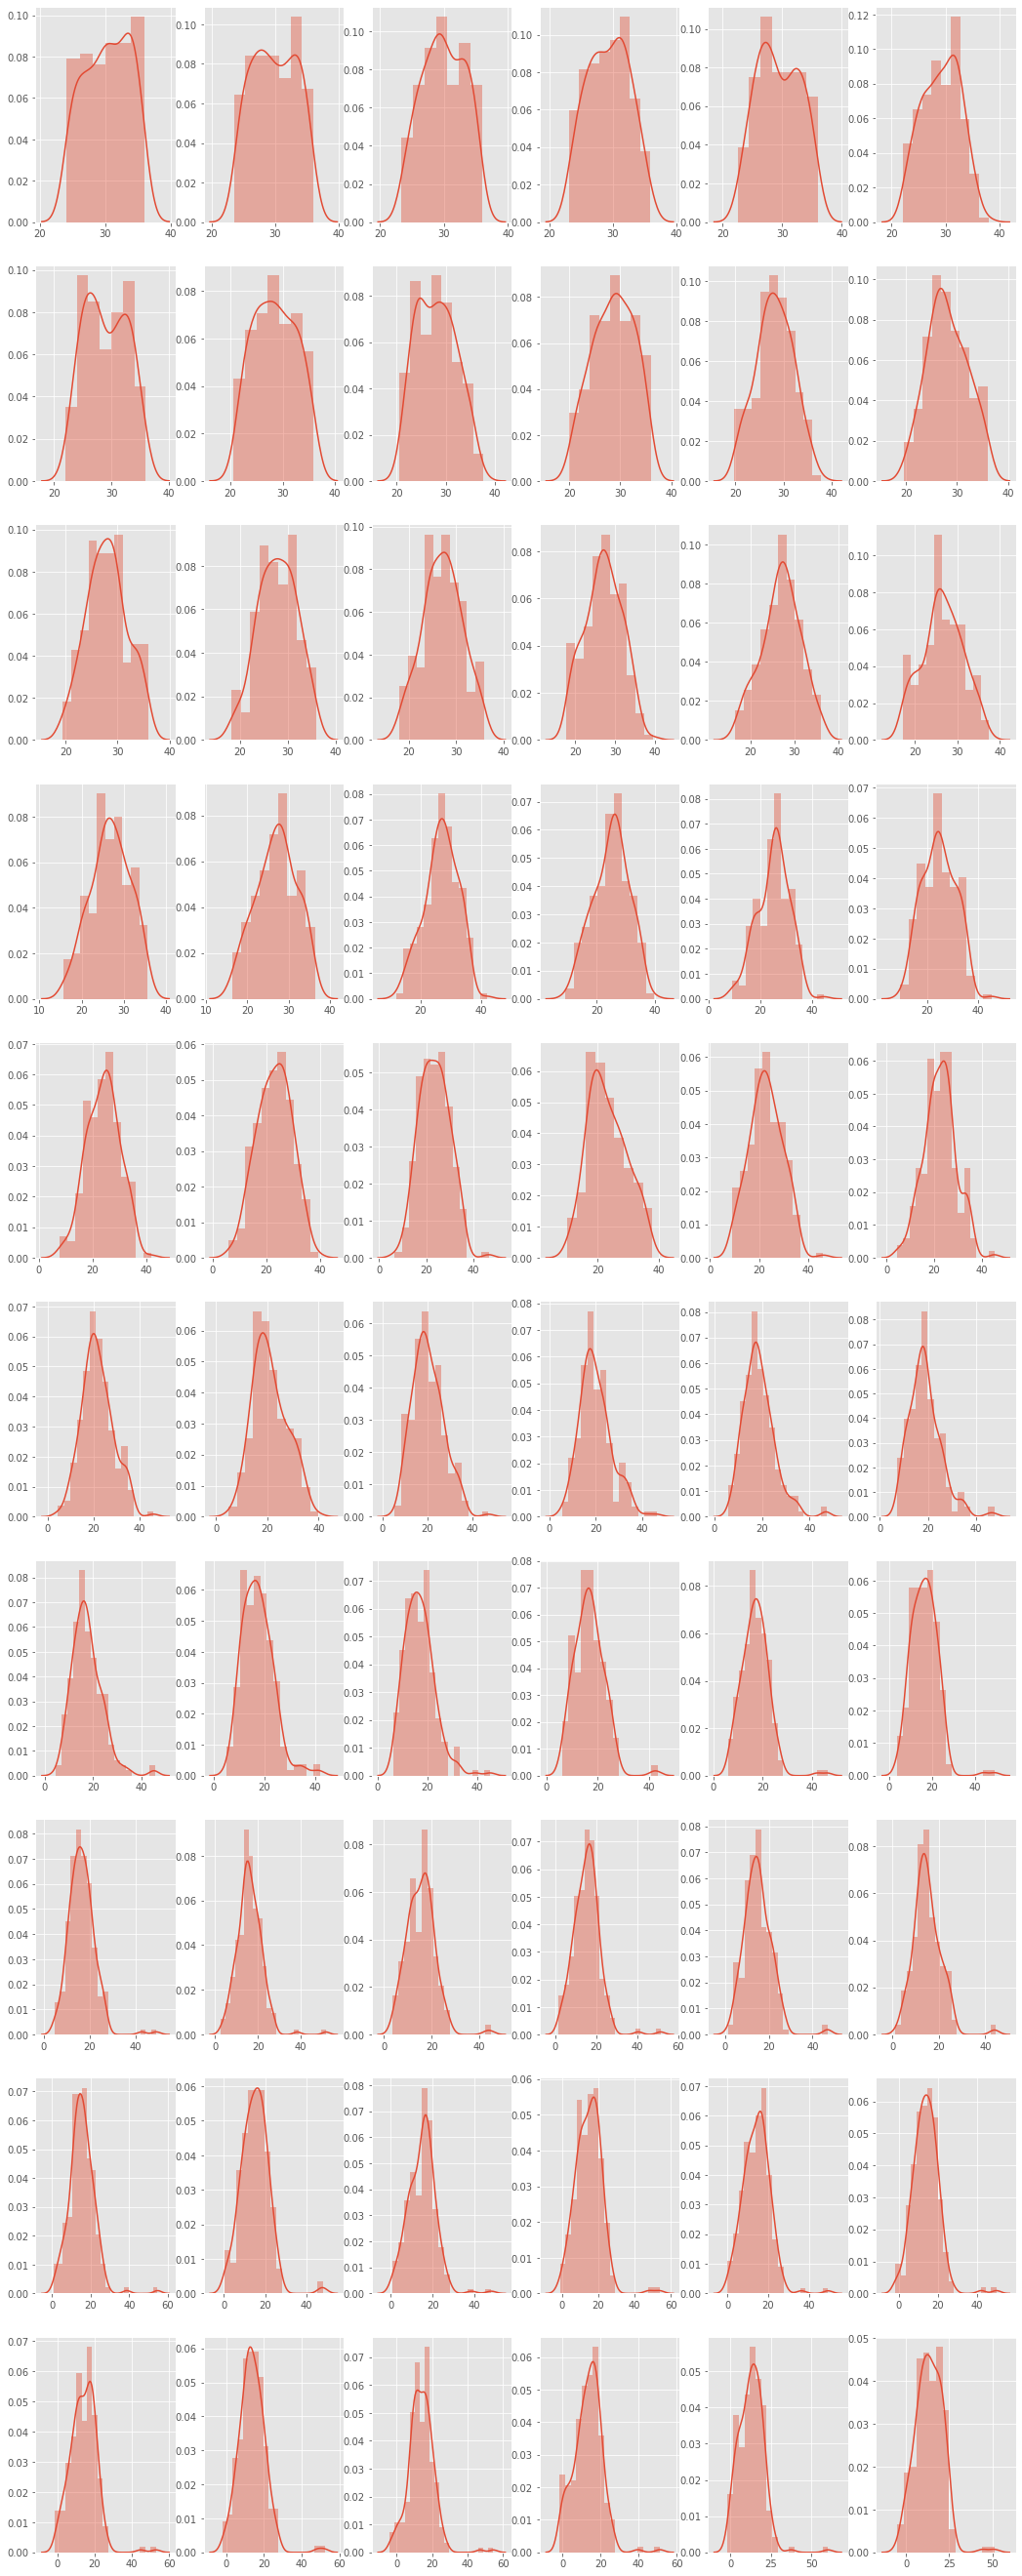

In [ ]:
fig, ax = plt.subplots(10,6, figsize = (18,48))
ax = ax.reshape(-1)
for i in range(60):
  sns.distplot(data[:,i],  ax = ax[i])

Using Histogram, we can make quite good approximation that our attributes are normally distribured with very few outliers, hence we can use StandardScaler to scale down our data.

Standard Scaler make use of assumption that our features are almost normally ditributed and then scale it by subtracting mean and dividing by standard deviation.

In [ ]:
scaler = StandardScaler()
datas = scaler.fit_transform(data)

### **Checking Correlations**

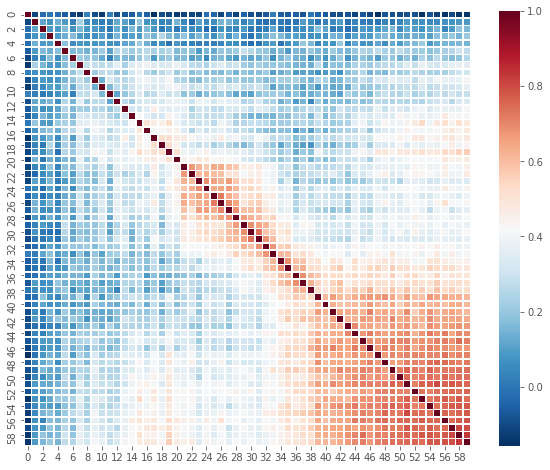

In [ ]:
df_datas = pd.DataFrame(datas)
plt.figure(figsize= (10,8))
sns.heatmap(df_datas.corr(),  
            cmap='RdBu_r',
            linewidth=0.5)

* There are not such attributes with high correlation such that we can remove on and work with the other one only

### **Dimentions View**

In [ ]:
def dimentions_plotting(data, label, dim1 = 0, dim2 = 1, iter = 5):
  fig, ax = plt.subplots(1, iter, figsize = (18,8))
  for i in range(len(ax)):
    f1 = data[:, dim1 + i]
    f2 = data[:, dim2 + i]
    sns.scatterplot(f1, f2, hue = label.reshape(-1), ax= ax[i],  palette=["C0", "C1"])
  plt.suptitle("2-d View of data")

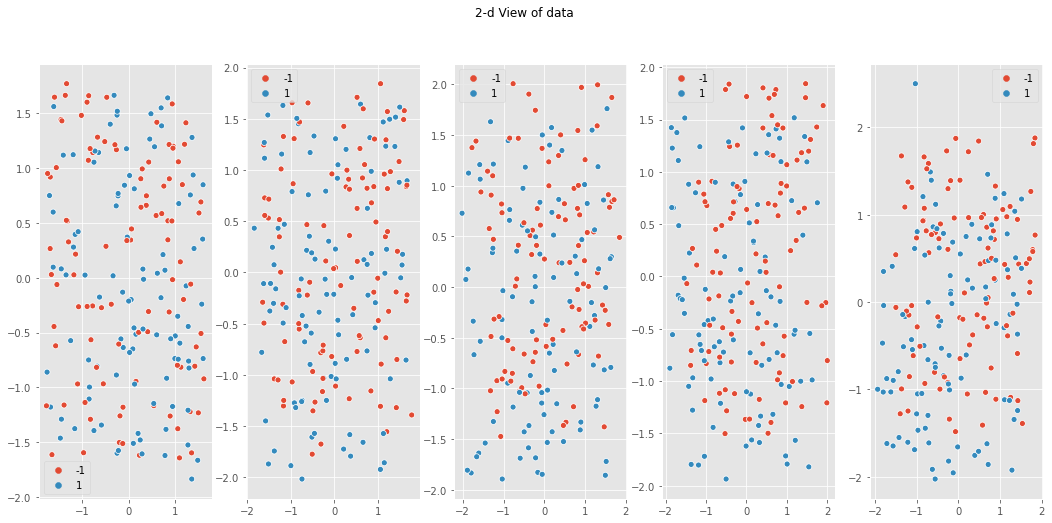

In [ ]:
dimentions_plotting(datas, label)

### **3-d View of Alterted dimentions**

In [ ]:
def view_3d(data, label, dim1 = 0, dim2 = 1, dim3 = 2):
  d1 = data[:, dim1]
  d2 = data[:, dim2]
  d3 = data[:, dim3]
  fig = px.scatter_3d(data, x=d1, y=d2, z=d3,
              color= label)
  
  fig.update_layout(scene = dict(
                    xaxis_title='dimesion 1',
                    yaxis_title='dimesion 2',
                    zaxis_title='dimesion 3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

In [ ]:
view_3d(data, label)

* By just some interactions between dimensions, we can ultimately find an efficient decision boundary.

* We will look at this later in the modelling part





### **Using SVM Kernel to visualize the decision boundary**

In [ ]:
check = data[:,0:2]
check.shape

(200, 2)

using a linear kernel function results in finding a hyperplane (decision boundary) in the same feature space as our data.

(23.126, 36.87443826573282)

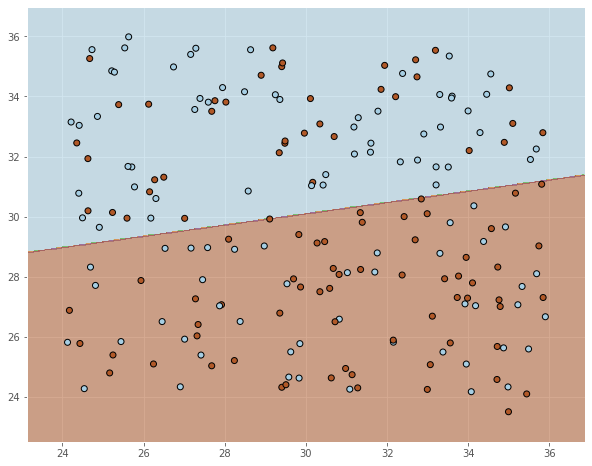

In [ ]:
svc = SVC(kernel='linear').fit(check, label)
x_min, x_max = check[:, 0].min() - 1, check[:, 0].max() + 1
y_min, y_max = check[:, 1].min() - 1, check[:, 1].max() + 1
h = (x_max / x_min)/60
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# plt.subplot(1, 1, 1)
plt.figure(figsize= (10,8))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(check[:, 0], check[:, 1], c=label, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.xlim(xx.min(), xx.max())

using a polynomial kernel function results in finding a hyperplane (decision boundary) in the higher degree feature space as defined in the function below

(23.126, 36.87443826573282)

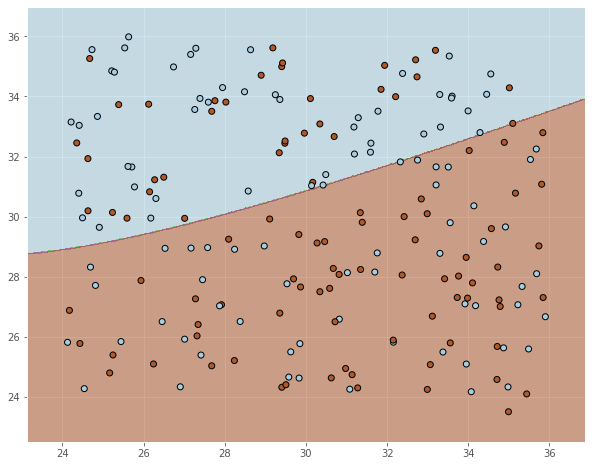

In [ ]:
svc = SVC(kernel='poly').fit(check, label)
x_min, x_max = check[:, 0].min() - 1, check[:, 0].max() + 1
y_min, y_max = check[:, 1].min() - 1, check[:, 1].max() + 1
h = (x_max / x_min)/60
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# plt.subplot(1, 1, 1)
plt.figure(figsize= (10,8))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(check[:, 0], check[:, 1], c=label, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.xlim(xx.min(), xx.max())

using a Radial basis function as a kernel function results in finding a hyperplane (decision boundary) in the infinite feature space which makes it very effective

(23.126, 36.87443826573282)

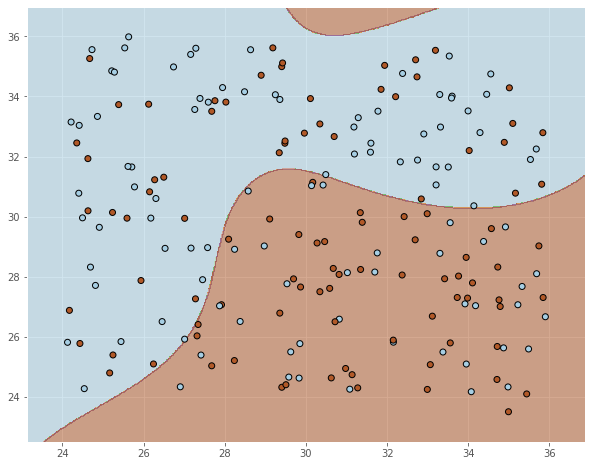

In [ ]:
svc = SVC(kernel='rbf').fit(check, label)
x_min, x_max = check[:, 0].min() - 1, check[:, 0].max() + 1
y_min, y_max = check[:, 1].min() - 1, check[:, 1].max() + 1
h = (x_max / x_min)/60
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# plt.subplot(1, 1, 1)
plt.figure(figsize= (10,8))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(check[:, 0], check[:, 1], c=label, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.xlim(xx.min(), xx.max())

### **Modelling**

In [ ]:
def train_test_split(data, label, test_size = 0.3, seed = 42):
    ## shuffle data
    np.random.seed(seed)
    ii = np.random.permutation(data.shape[0])
    data = data[ii,:]
    label = label.reshape(-1)
    label = label[ii]
    k = int(data.shape[0] * (1-test_size))

    ## split data
    xtr = data[:k,:]
    ytr = label[:k]
    xte = data[k:,:]
    yte = label[k:]
    return xtr, ytr, xte, yte

In [ ]:
xtr, ytr, xte, yte = train_test_split(datas, label)

In [ ]:
xtr.shape

(140, 60)

In [ ]:
def mask(k, data):
  points = data.shape[0]
  cut = int(points/k)
  z = np.zeros((k, points))
  for i in range(k):
    z[i,i*cut:(i+1)*cut] = 1
  z = (z==1)
  return z 

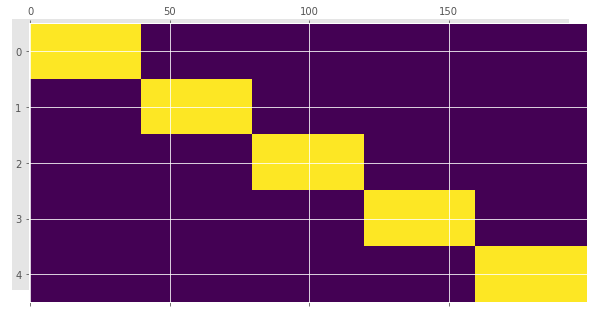

In [ ]:
msk = mask(5, data)
plt.figure(figsize=(10,5))
plt.xticks([])
plt.yticks([])
plt.matshow(msk, fignum=1, aspect='auto')

### **Nested Cross Validation**

In [ ]:
def nested_cv(modell, dct, data, label, k = 5, seed = 42, output = 'count'):
  # c : must be a list or iteratable
  # func : must be a list or iteratable
  # data : nxd training instances
  # ytr : corresponding labels
  label = label.reshape(-1)
  # cut = int(data.shape[0]/k)
  # param_value = np.asarray(param_value) ##

  ## Shuffling data
  np.random.seed(seed)
  ii = np.random.permutation(data.shape[0])
  data = data[ii,:]
  label = label[ii]
  
  msk = mask(k, data)
  idict = {}



  key = list(dct.keys())[0]
  v = list(dct.values())[0]
  n = len(v)
  lst = list(np.zeros(n))
  for i in range(len(v)):
    lst[i] = dct.copy()
    lst[i][key] = v[i]

  
  acc_i = []
  best_param = []

  for i in range(k):
    ii = (msk[i,:])
    ith_test = data[ii,:] ##
    ith_test_label = label[ii]
    inv = np.invert(ii)
    ith_train = data[inv,:] ##
    ith_train_label = label[inv]
    j_msk = mask(k-1, ith_train)
    avg_j_acc = []
    for f in lst:
      acc_j = []
      for j in range(k-1):
        ii2 = j_msk[j,:]
        jth_test = ith_train[ii2,:]
        jth_test_label = ith_train_label[ii2]
        invj = np.invert(ii2)
        jth_train = ith_train[invj, :]
        jth_train_label = ith_train_label[invj]

        model = modell(**f).fit(jth_train, jth_train_label)
        acc_j.append(model.score(jth_test, jth_test_label))
      avg_j_acc.append(sum(acc_j)/len(acc_j))
    
    # avg_j_acc : avg accuracy for each lambda for ith iteration

    # Now we have for each param_value, its avg_accuracy
    avg_j_acc_array = np.asarray(avg_j_acc)
    args = np.argsort(-1*avg_j_acc_array)[0]
    best_param.append(v[args]) ## check
    idict[key] = best_param[-1]
    model_outer = modell(**idict).fit(ith_train, ith_train_label)
    acc_i.append(model_outer.score(ith_test, ith_test_label))
  avg_acc_i = sum(acc_i)/len(acc_i)
  if output == 'count':
    ii3 = np.asarray(best_param)
    un, count = np.unique(ii3, return_counts= True)
    final_param = np.argsort(-1*count)[0]
    final_param = un[final_param]
    print(f"The average accuracy achieved is {avg_acc_i *100}% from value of parameter being = {final_param}")
  elif output == 'avg':
    final_param = sum(best_param)/len(best_param)
    print(f"The average accuracy achieved is {avg_acc_i *100}% from value of parameter being = {final_param}")

  
  return final_param, best_param, avg_j_acc_array, v

### **SVM**

## **Selecting C parameter**

In [ ]:
dct = {'C': [0.1, 0.5, 0.7, 1, 1.5]}

c, b, acc_svm, c_params = nested_cv(SVC, dct, xtr, ytr, output= 'avg')

The average accuracy achieved is 97.14285714285715% from value of parameter being = 1.24


Text(0, 0.5, 'Respective counts')

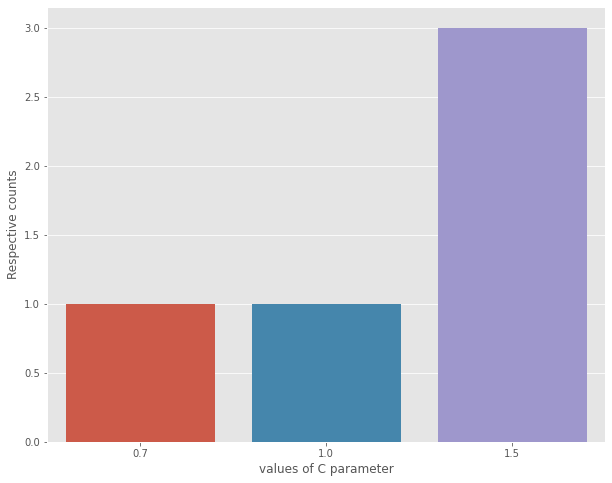

In [ ]:
plt.figure(figsize= (10,8))
sns.countplot(b)
plt.xlabel("values of C parameter")
plt.ylabel("Respective counts")

Text(0, 0.5, 'Respective accuracies')

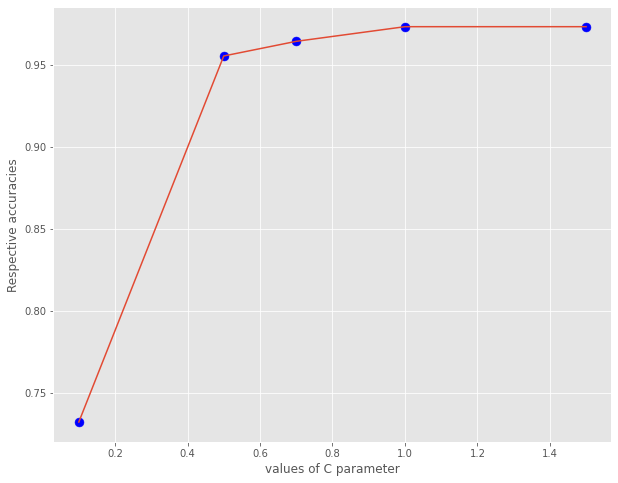

In [ ]:
plt.figure(figsize= (10,8))
plt.scatter(c_params, acc_svm, c = 'blue', s = 80)
plt.plot(c_params, acc_svm)
plt.xlabel("values of C parameter")
plt.ylabel("Respective accuracies")

## **Selecting Kernel Function**

In [ ]:
dct2 = {'kernel':['rbf', 'poly', 'linear']}
func, best_kernel, acc_kernel, k_params = nested_cv(SVC, dct2, xtr, ytr)

The average accuracy achieved is 97.14285714285715% from value of parameter being = rbf


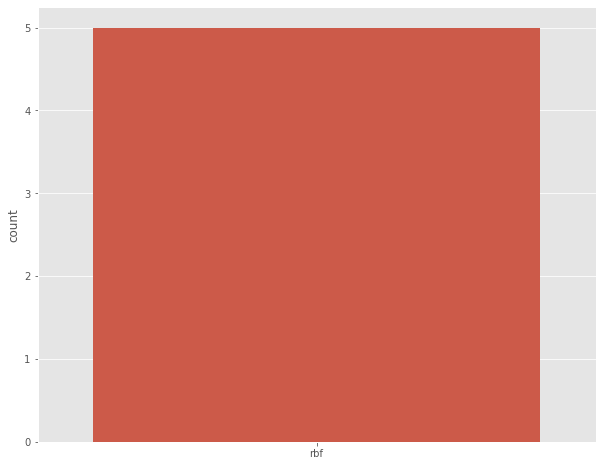

In [ ]:
plt.figure(figsize= (10,8))
sns.countplot(best_kernel)

Text(0, 0.5, 'Respective accuracies')

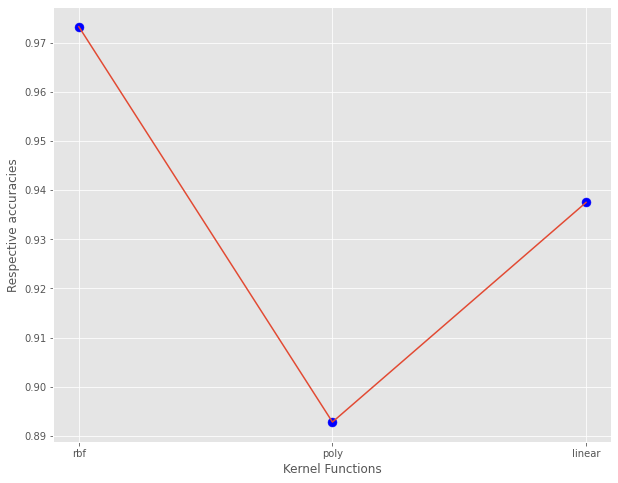

In [ ]:
plt.figure(figsize= (10,8))
plt.scatter(k_params, acc_kernel, c = 'blue', s = 80)
plt.plot(k_params, acc_kernel)
plt.xlabel("Kernel Functions")
plt.ylabel("Respective accuracies")

### **Selecting Gamma Value**

In [ ]:
dct3 = {'gamma':[0.01, 0.05, 0.1, 0.5]}
gamma, best_gamma, acc_gamma, gamma_params = nested_cv(SVC, dct3, xtr, ytr)

The average accuracy achieved is 97.14285714285715% from value of parameter being = 0.01


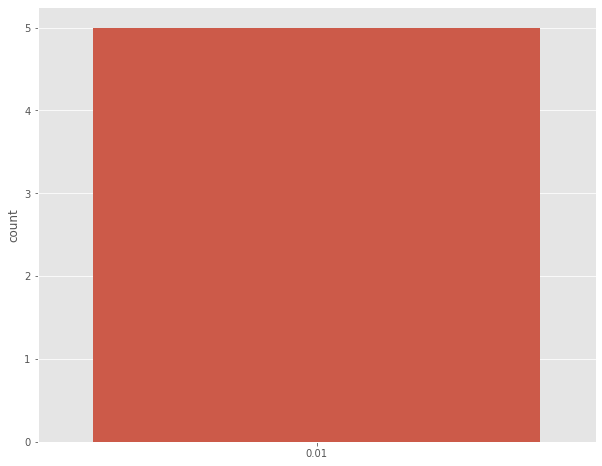

In [ ]:
plt.figure(figsize= (10,8))
sns.countplot(best_gamma)

Text(0, 0.5, 'Respective accuracies')

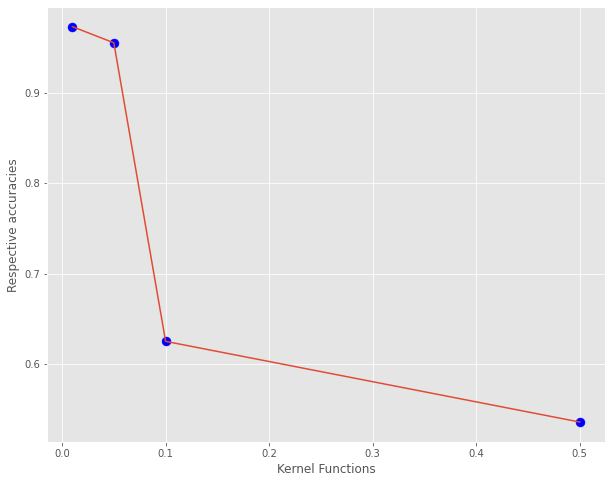

In [ ]:
plt.figure(figsize= (10,8))
plt.scatter(gamma_params, acc_gamma, c = 'blue', s = 80)
plt.plot(gamma_params, acc_gamma)
plt.xlabel("Kernel Functions")
plt.ylabel("Respective accuracies")

Fitting the model

In [ ]:
svm = SVC(C = c, kernel = func, gamma= gamma, probability= True).fit(xtr, ytr)
ypred = svm.predict(xte)
print(f"The accuracy from SVM is: {svm.score(xte, yte)}")

The accuracy from SVM is: 1.0


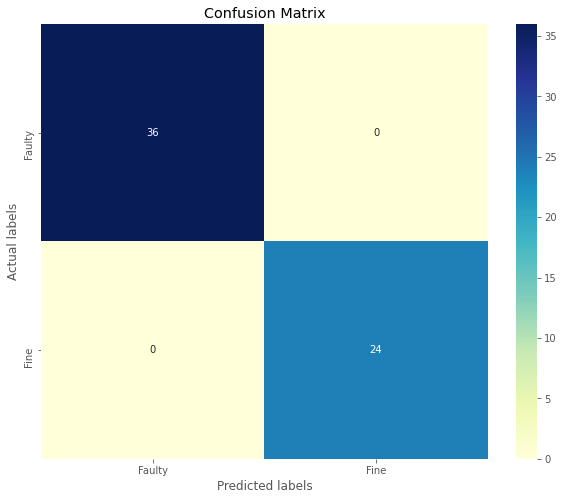

In [ ]:
cm = confusion_matrix(yte, ypred)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Faulty', 'Fine']); ax.yaxis.set_ticklabels(['Faulty', 'Fine']);

In [ ]:
print(classification_report(yte, ypred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        24

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Text(0.5, 1.0, 'SVM ROC Curve')

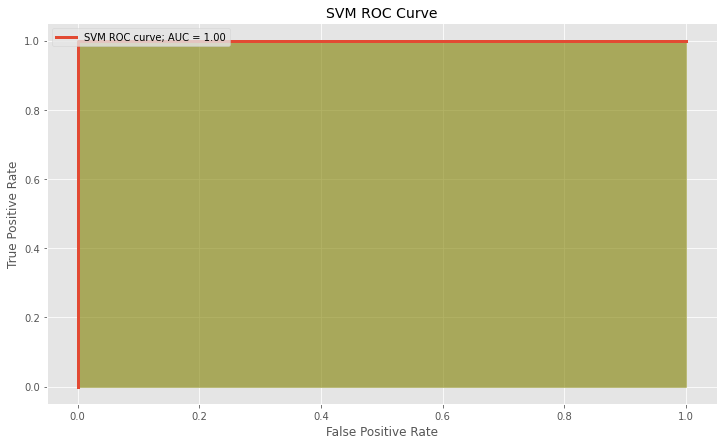

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba = svm.predict_proba(xte)
svm_fpr, svm_tpr, thresholds2 = roc_curve(yte, y_hat_proba[:,1])
svm_auc = auc(svm_fpr, svm_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(svm_fpr, svm_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(svm_fpr, svm_tpr, linewidth=3, label='SVM ROC curve; AUC = %0.2f' % svm_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve', size=14)

### **K Nearest Neighbors**

* It uses an assumption that all 'k' nearby points have the same labels hence we have to tune the value of 'k'

In [ ]:
dctk = {'n_neighbors' : [3,4,5,6,7,8]}
k, best_k, acc_k, k_params = nested_cv(KNeighborsClassifier, dctk, xtr, ytr)

The average accuracy achieved is 97.14285714285715% from value of parameter being = 4


Text(0, 0.5, 'respective accuracies')

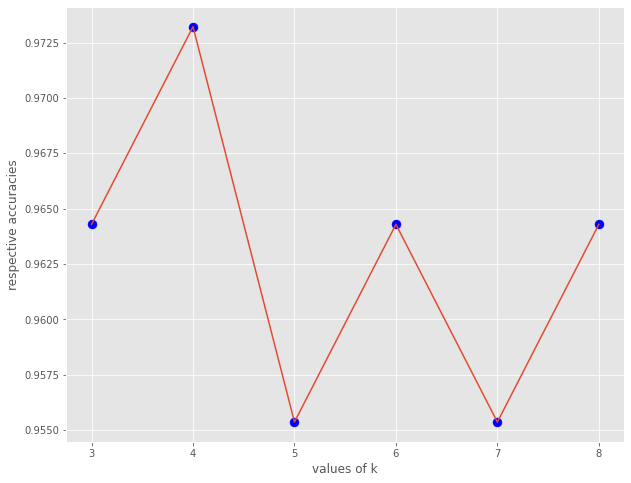

In [ ]:
plt.figure(figsize= (10,8))
plt.plot(k_params, acc_k)
plt.scatter(k_params, acc_k, c = 'b', s = 80)
plt.xlabel("values of k")
plt.ylabel("respective accuracies")

In [ ]:
knn = KNeighborsClassifier(n_neighbors= k).fit(xtr, ytr)
ypred_knn = knn.predict(xte)
print(f"the accuracy achieved is {knn.score(xte, yte)}")

the accuracy achieved is 1.0


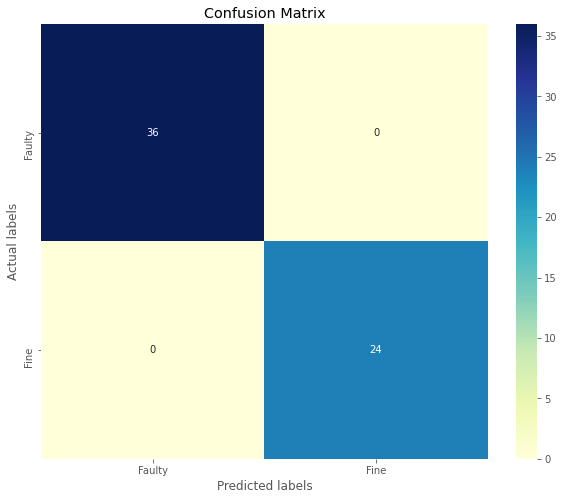

In [ ]:
cm = confusion_matrix(yte, ypred_knn)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Faulty', 'Fine']); ax.yaxis.set_ticklabels(['Faulty', 'Fine']);

In [ ]:
print(classification_report(yte, ypred_knn))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        24

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Text(0.5, 1.0, 'KNN ROC Curve')

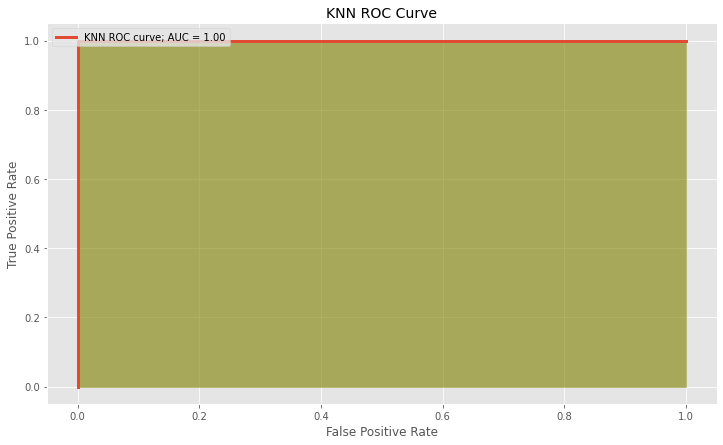

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_knn = knn.predict_proba(xte)
knn_fpr, knn_tpr, thresholds2 = roc_curve(yte, y_hat_proba_knn[:,1])
knn_auc = auc(knn_fpr, knn_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr, knn_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(knn_fpr, knn_tpr, linewidth=3, label='KNN ROC curve; AUC = %0.2f' % knn_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve', size=14)

### **Random Forest**

In [ ]:
dctforest = {'max_depth': [20, 40, 50]}
dctforest2 = {'n_estimators': [80,100,150]}
maxd, bestd, acc_d, maxparam = nested_cv(RandomForestClassifier, dctforest, xtr, ytr)
maxn, bestn, acc_n, nparam = nested_cv(RandomForestClassifier, dctforest2, xtr, ytr)

The average accuracy achieved is 97.14285714285715% from value of parameter being = 20
The average accuracy achieved is 95.00000000000001% from value of parameter being = 150


Text(0.5, 0, 'max-depth')

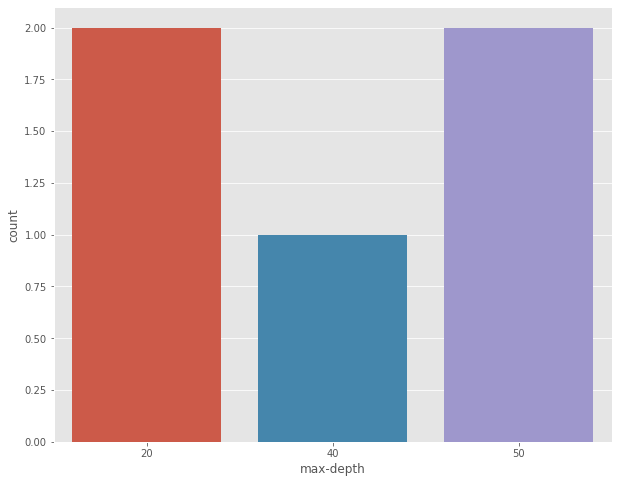

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(bestd)
plt.xlabel("max-depth")

Text(0.5, 0, 'n_estimators')

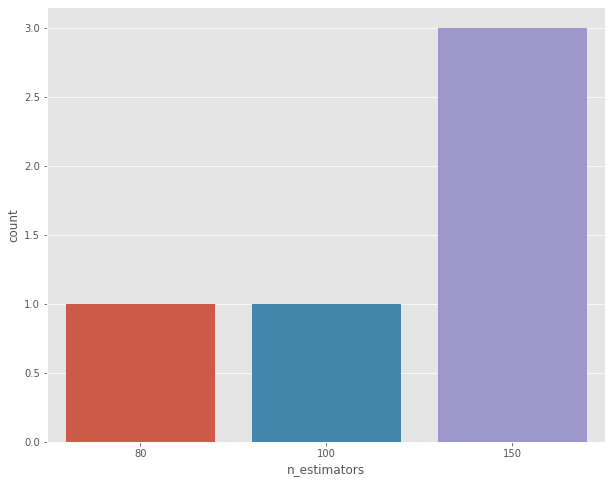

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(bestn)
plt.xlabel("n_estimators")

Using GridSearchCV 

In [ ]:
def tuning_forest(xtr, ytr, estimator = [80,100,150], max_depth = [20,40,50]):
  params = {'n_estimators':estimator, 'max_depth': max_depth}
  forest = RandomForestClassifier()
  grid = GridSearchCV(forest, params)
  grid.fit(xtr, ytr)
  my_dict = {}
  dct = grid.cv_results_
  my_choice = (np.array([0,0,0,0,1,1,0,1,1,1,1,1,1,1,1])) == 1
  allkeys = grid.cv_results_.keys()
  for count, i in enumerate(allkeys):
    if my_choice[count]:
      my_dict[i] = dct[i]

  df = pd.DataFrame(my_dict)
  return df

In [ ]:
df = tuning_forest(xtr, ytr)
df.head()

,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20,80,1.000000,1.000000,0.964286,0.964286,0.964286,0.978571,0.017496,1
1,20,100,1.000000,0.964286,0.964286,0.964286,0.964286,0.971429,0.014286,3
2,20,150,1.000000,0.964286,0.964286,0.964286,0.964286,0.971429,0.014286,3
3,40,80,0.964286,0.928571,0.964286,0.964286,0.964286,0.957143,0.014286,8
4,40,100,1.000000,0.928571,0.964286,0.928571,1.000000,0.964286,0.031944,6


Best values

In [ ]:
x = df['param_max_depth']
y = df['param_n_estimators']
z = df['mean_test_score']
fig = px.scatter_3d(data, x=x, y=y, z=z)

fig.update_layout(scene = dict(
                    xaxis_title='max_depth',
                    yaxis_title='n_estimator',
                    zaxis_title='mean_test_score'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

In [ ]:
forest = RandomForestClassifier(n_estimators = maxn, max_depth = maxd).fit(xtr, ytr)
ypred_forest = forest.predict(xte)
print(f"The accuracy achieved using RandomForest classifier is {forest.score(xte, yte)}")

The accuracy achieved using RandomForest classifier is 1.0


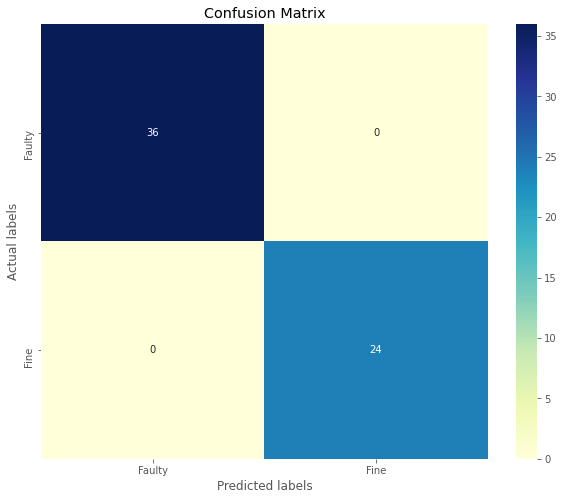

In [ ]:
cm = confusion_matrix(yte, ypred_forest)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Faulty', 'Fine']); ax.yaxis.set_ticklabels(['Faulty', 'Fine']);

In [ ]:
print(classification_report(yte, ypred_forest))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        24

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Text(0.5, 1.0, 'Random Forest ROC Curve')

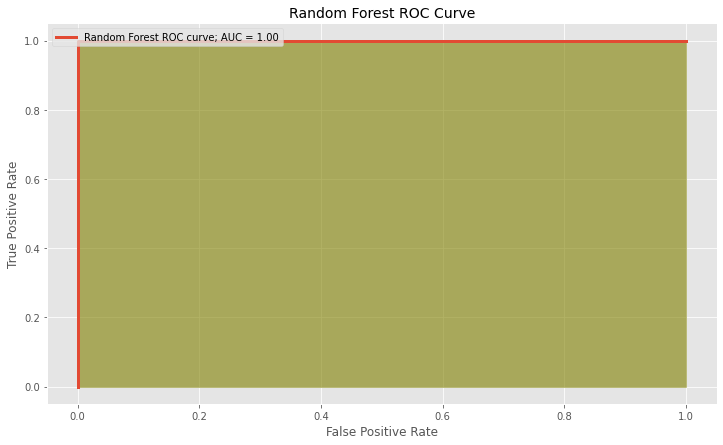

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_forest = forest.predict_proba(xte)
forest_fpr, forest_tpr, thresholds2 = roc_curve(yte, y_hat_proba_forest[:,1])
forest_auc = auc(forest_fpr, forest_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(forest_fpr, forest_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(forest_fpr, forest_tpr, linewidth=3, label='Random Forest ROC curve; AUC = %0.2f' % forest_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve', size=14)

### **Decision Tree Classifier**

In [ ]:
dct_tree = {"max_depth":[10, 20, 30, 40, 50, 70]}
tree_depth, best_depth, acc_tree, t_params = nested_cv(DecisionTreeClassifier, dct_tree, xtr, ytr, output= 'avg')

The average accuracy achieved is 81.42857142857143% from value of parameter being = 50.0


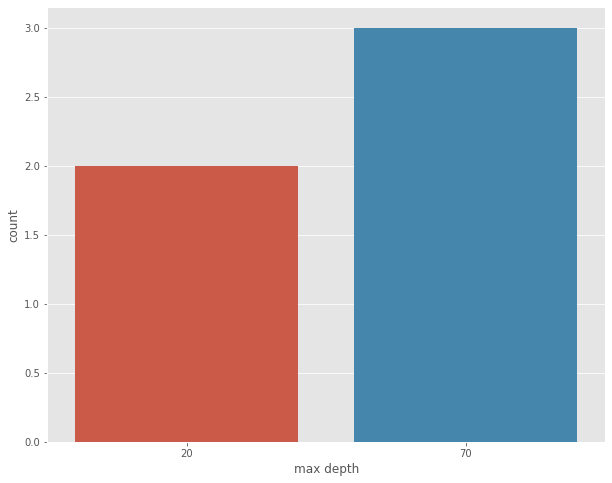

In [ ]:
plt.figure(figsize= (10,8))
plt.xlabel("max depth")
sns.countplot(best_depth)

Text(0, 0.5, 'Respective accuracies')

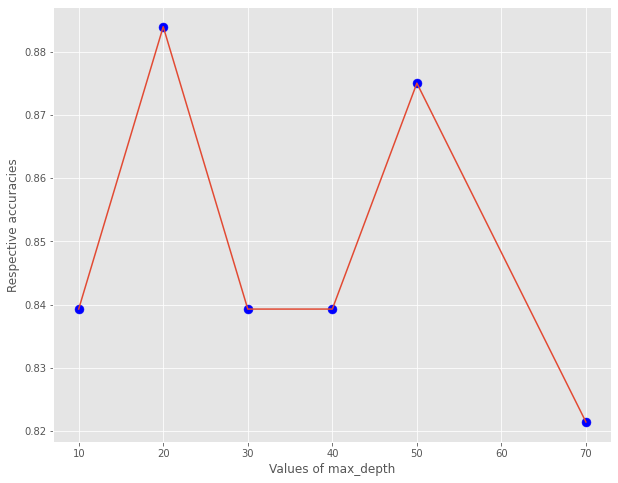

In [ ]:
plt.figure(figsize= (10,8))
plt.scatter(t_params, acc_tree, c= 'b', s = 80)
plt.plot(t_params, acc_tree)
plt.xlabel("Values of max_depth")
plt.ylabel("Respective accuracies")

In [ ]:
tree = DecisionTreeClassifier(max_depth= tree_depth).fit(xtr, ytr)
ypred_tree = tree.predict(xte)
print(f"the accuracy achieved using Decision Tree is {tree.score(xte, yte)}")

the accuracy achieved using Decision Tree is 0.8833333333333333


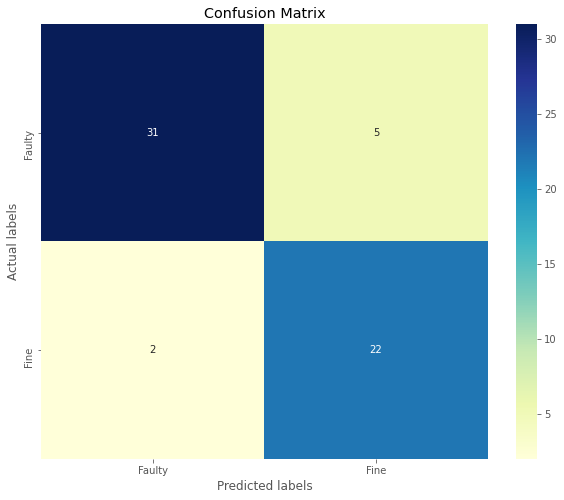

In [ ]:
cm = confusion_matrix(yte, ypred_tree)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Faulty', 'Fine']); ax.yaxis.set_ticklabels(['Faulty', 'Fine']);

In [ ]:
print(classification_report(yte, ypred_tree))

              precision    recall  f1-score   support

          -1       0.94      0.86      0.90        36
           1       0.81      0.92      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60



Text(0.5, 1.0, 'Decision Tree ROC Curve')

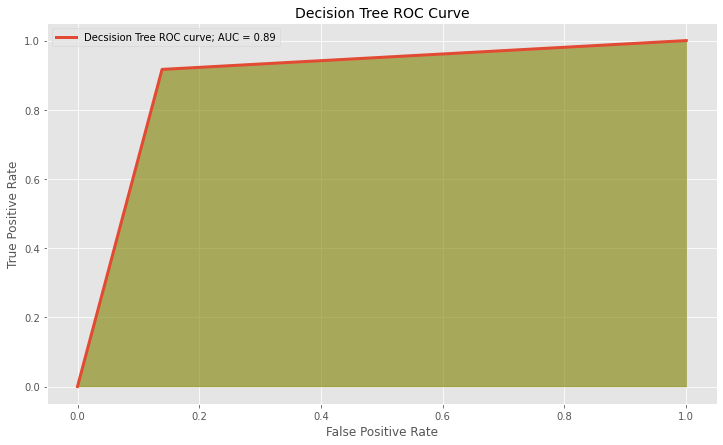

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_tree = tree.predict_proba(xte)
tree_fpr, tree_tpr, thresholds2 = roc_curve(yte, y_hat_proba_tree[:,1])
tree_auc = auc(tree_fpr, tree_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(tree_fpr, tree_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(tree_fpr, tree_tpr, linewidth=3, label='Decsision Tree ROC curve; AUC = %0.2f' % tree_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve', size=14)

### **Logistic Regression**

In [ ]:
dct_logits = {"C":[0.01, 0.05, 0.1 , 0.5, 0.8, 1, 1.2]}
logit_c, best_logit_c, acc_logit, logit_param = nested_cv(LogisticRegression, dct_logits, xtr, ytr, output= 'avg')

The average accuracy achieved is 97.14285714285715% from value of parameter being = 0.32


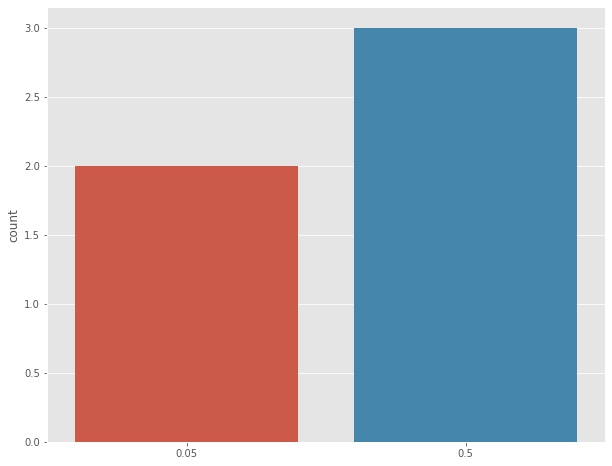

In [ ]:
plt.figure(figsize= (10,8))
sns.countplot(best_logit_c)

Text(0, 0.5, 'Respective accuracies')

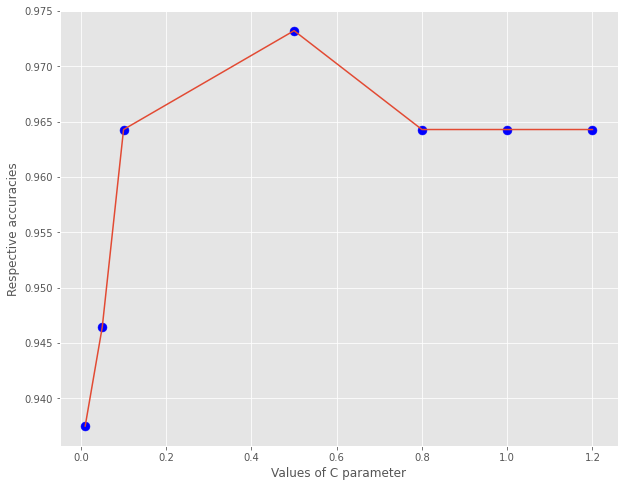

In [ ]:
plt.figure(figsize= (10,8))
plt.scatter(logit_param, acc_logit, c= 'b', s = 80)
plt.plot(logit_param, acc_logit)
plt.xlabel("Values of C parameter")
plt.ylabel("Respective accuracies")

In [ ]:
logit = LogisticRegression(C = logit_c, max_iter= 2000).fit(xtr, ytr)
ypred_logit = logit.predict(xte)
print(f"the final accuracy we achieved is {logit.score(xte, yte)}")

the final accuracy we achieved is 0.9666666666666667


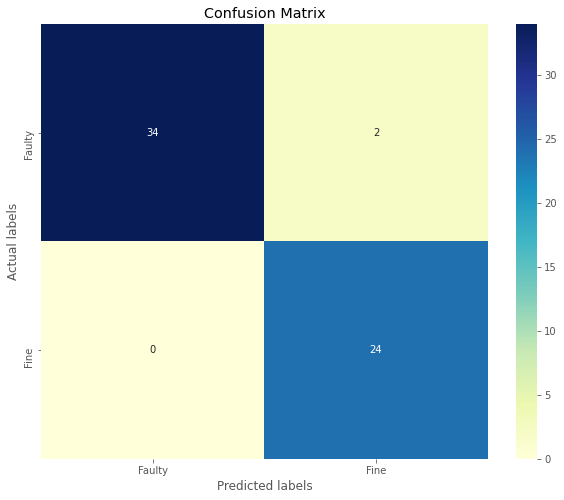

In [ ]:
cm = confusion_matrix(yte, ypred_logit)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Faulty', 'Fine']); ax.yaxis.set_ticklabels(['Faulty', 'Fine']);

In [ ]:
print(classification_report(yte, ypred_logit))

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        36
           1       0.92      1.00      0.96        24

    accuracy                           0.97        60
   macro avg       0.96      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



Text(0.5, 1.0, 'Logistic Regression ROC Curve')

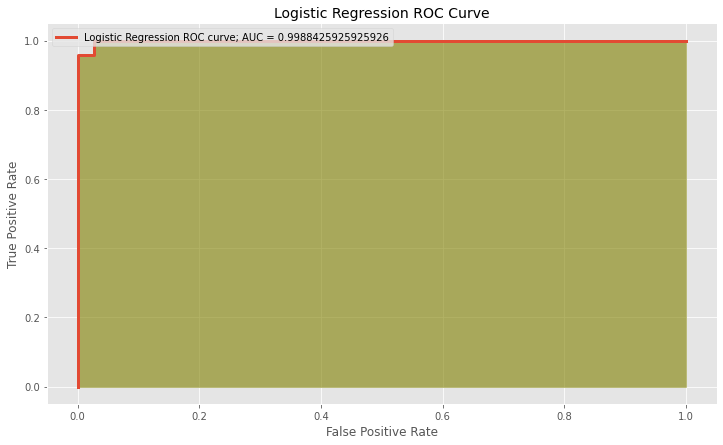

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_logit = logit.predict_proba(xte)
logit_fpr, logit_tpr, thresholds2 = roc_curve(yte, y_hat_proba_logit[:,1])
logit_auc = auc(logit_fpr, logit_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(logit_fpr, logit_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(logit_fpr, logit_tpr, linewidth=3, label='Logistic Regression ROC curve; AUC = ' + str(logit_auc))
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', size=14)

### **Conclusion**

Since there are 3 models that perform with accuracy of 100%, we can choose any one of them. The three best models are :
* SVM
* Random Forest
* K-Nearest Neighbor

We can conclude that in the higher dimensions, the problem was easy to solve hence we got the perfect result using these models.